In [13]:
import numpy as np
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import cartopy.util as cutil
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr

In [ ]:
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
data_dir = os.path.join(project_dir, 'data')
tcg_maps_dir = os.path.join(data_dir, 'IBTrACS', '2.5x2.5', 'TCG')
climate_indices_dir = os.path.join(data_dir, 'CI')

In [4]:
# Load and compute total number of TCGs from 1980 to 2021
tcg_list = []
tcg_list_month = []
for y in years:
    file = os.path.join(tcg_maps_dir, 'TCG_2.5x2.5_{}.nc'.format(y))
    ds = xr.open_dataset(file)
    tcg_ts = ds.tcg.sum(dim=['latitude', 'longitude'])
    tcg = ds.tcg.sum(dim='time')
    tcg_list.append(tcg)
    tcg_list_month.append(tcg_ts)
tcg_year = xr.concat(tcg_list, dim='year')
tcg_tot = tcg_year.sum(dim='year')
tcg_month = xr.concat(tcg_list_month, dim='time')
# Load PDO index
filename = os.path.join(climate_indices_dir, 'PDO.txt')
date_range = pd.date_range(start=f'{1980}-01-01', end=f'{2021}-12-01', freq='MS')
df_pdo = pd.DataFrame(index=date_range, columns=['PDO'])
data = pd.read_table(filename, sep='\s+', header=None)
for r, row in enumerate(df_pdo.iterrows()):
    idx = df_pdo.index[r]
    month = idx.month
    year = idx.year
    df_pdo.loc[idx, 'PDO'] = data[(data[0] == year)][month].values[0]

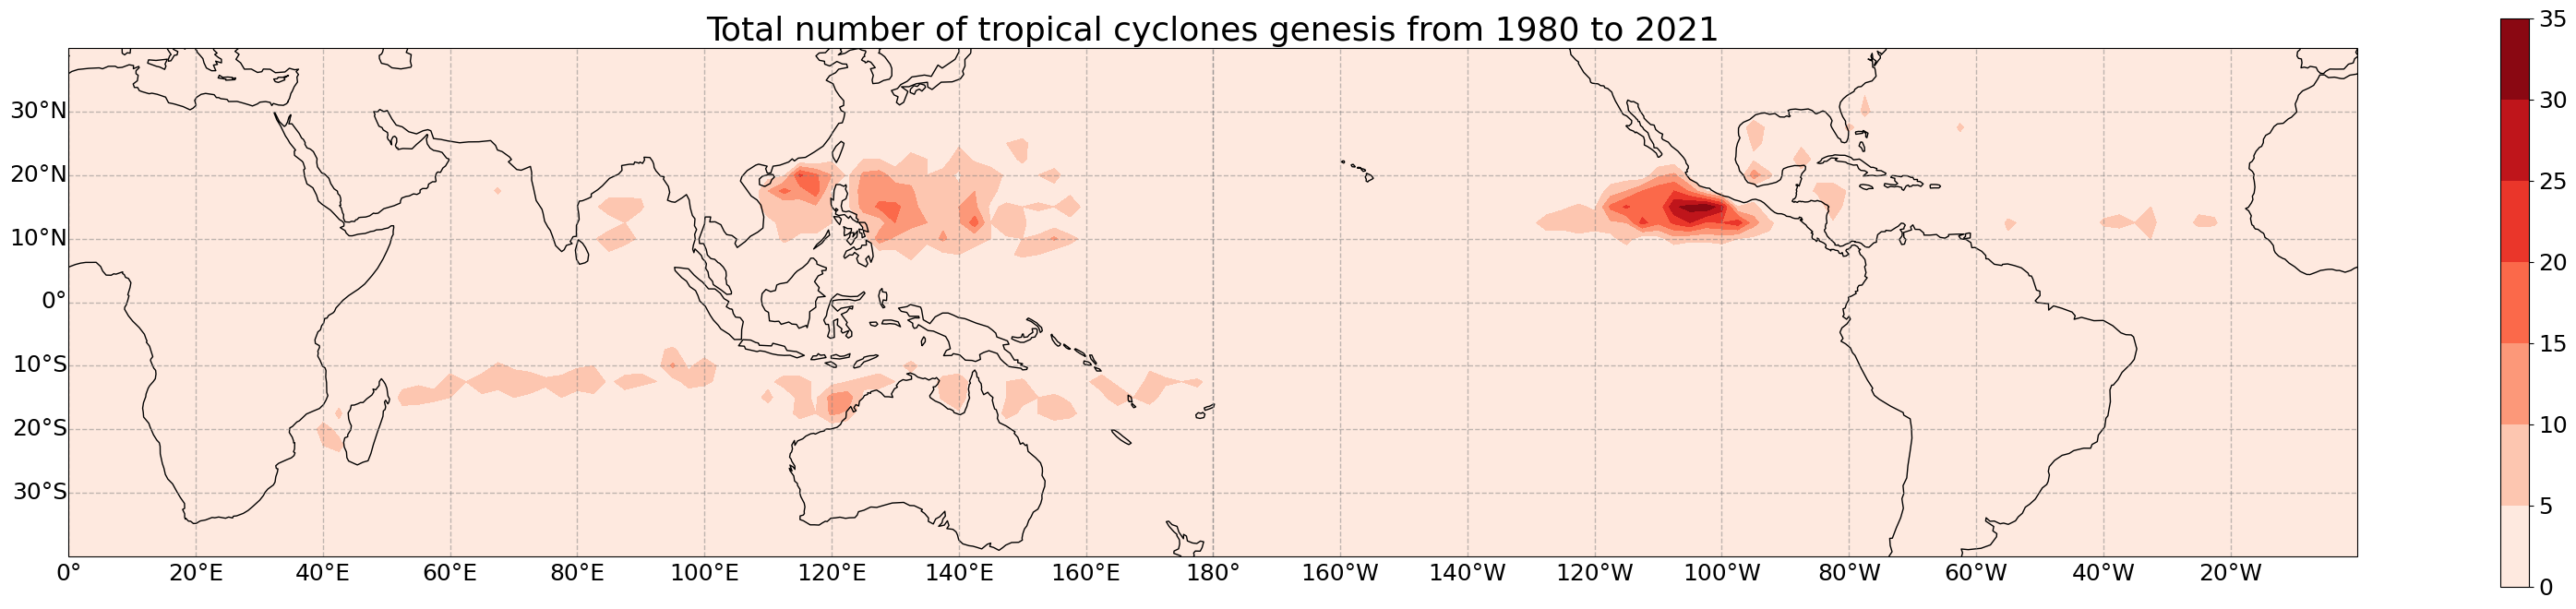

In [5]:
# Plot total number of tropical cyclones genesis from 1980 to 2021
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(tcg_tot.values, tcg_tot.longitude.values, tcg_tot.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(40, 8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.contourf(clon, clat, var, transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(field)
cbar.ax.tick_params(labelsize=18)

ax.set_title('Total number of tropical cyclones genesis from 1980 to 2021', size=26);

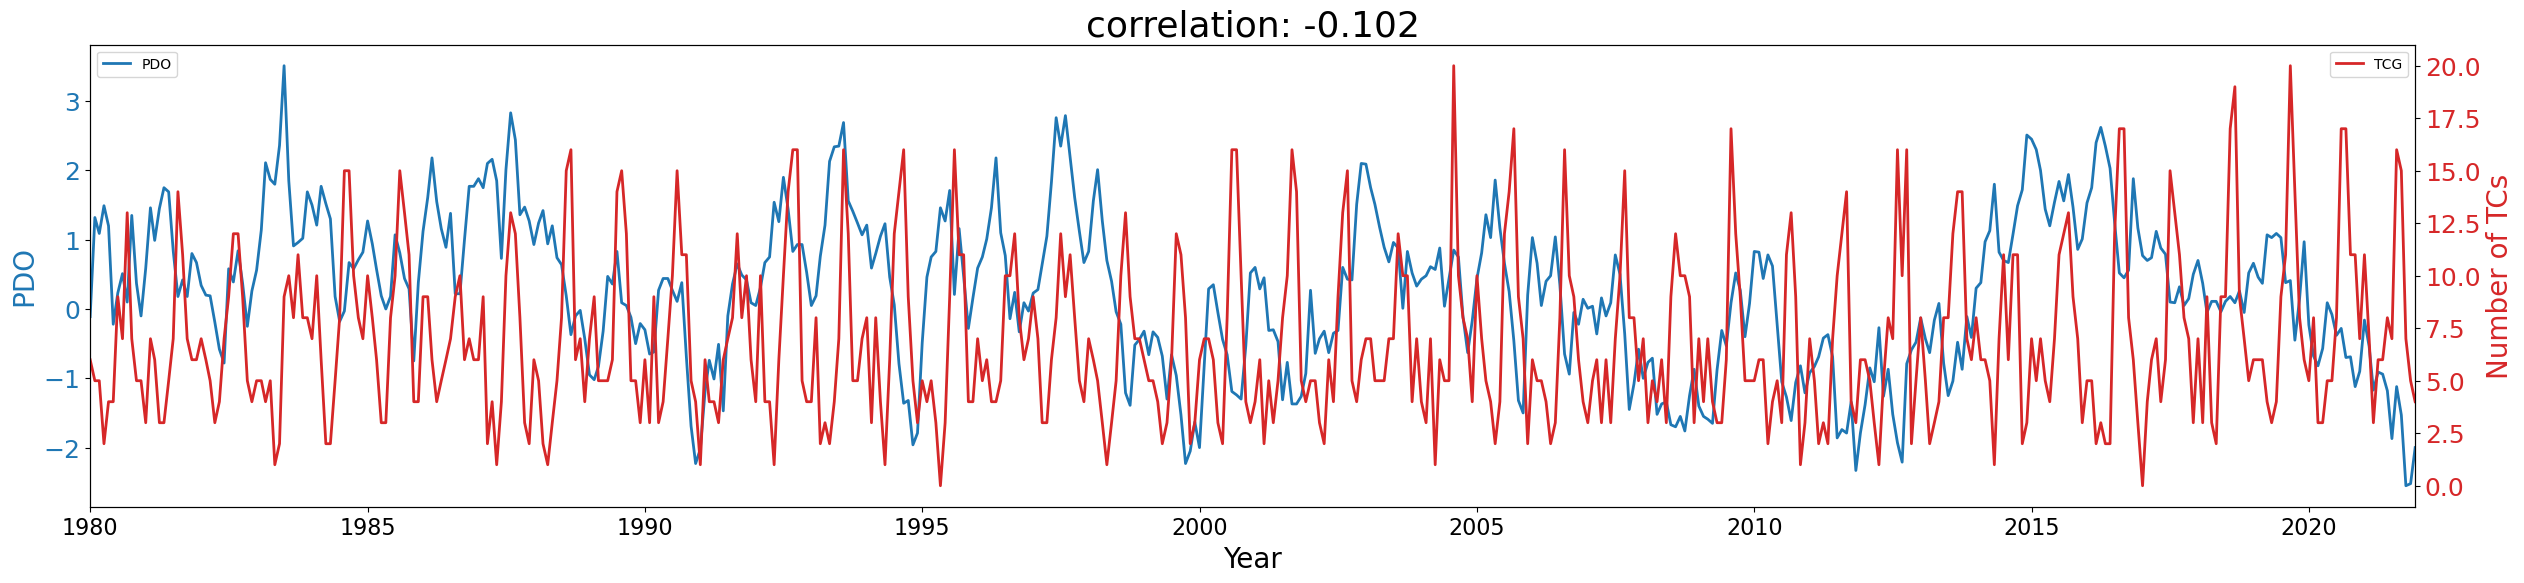

correlation between months and TCs: 0.286


In [6]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(30, 6))

r, _ = pearsonr(df_pdo.values.flatten(), tcg_month.values.flatten())

# Plot the first time series (PDO index) on the primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Year', size=20)
ax1.set_ylabel('PDO', color=color1, size=20)
ax1.plot(df_pdo.index, df_pdo.values, color=color1, linewidth=2, label="PDO")  # Ensure proper x-values
ax1.tick_params(axis='y', labelcolor=color1, labelsize=18)
ax1.set_title(f'correlation: {r:.3f}', size=26)

# Create a second y-axis for the second time series (TCG)
ax2 = ax1.twinx()  
color2 = 'tab:red'
ax2.set_ylabel('Number of TCs', color=color2, size=20)
ax2.plot(tcg_month.time, tcg_month.values, color=color2, linewidth=2, label="TCG")  # Ensure proper x-values
ax2.tick_params(axis='y', labelcolor=color2, labelsize=18)

# Set x-axis format properly
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlim([df_pdo.index.min(), df_pdo.index.max()])  # Set x-axis limits to match dataset

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

months = df_pdo.index.month.to_numpy()
rm, _ = pearsonr(months, tcg_month.values.flatten())
print(f'correlation between months and TCs: {rm:.3f}')


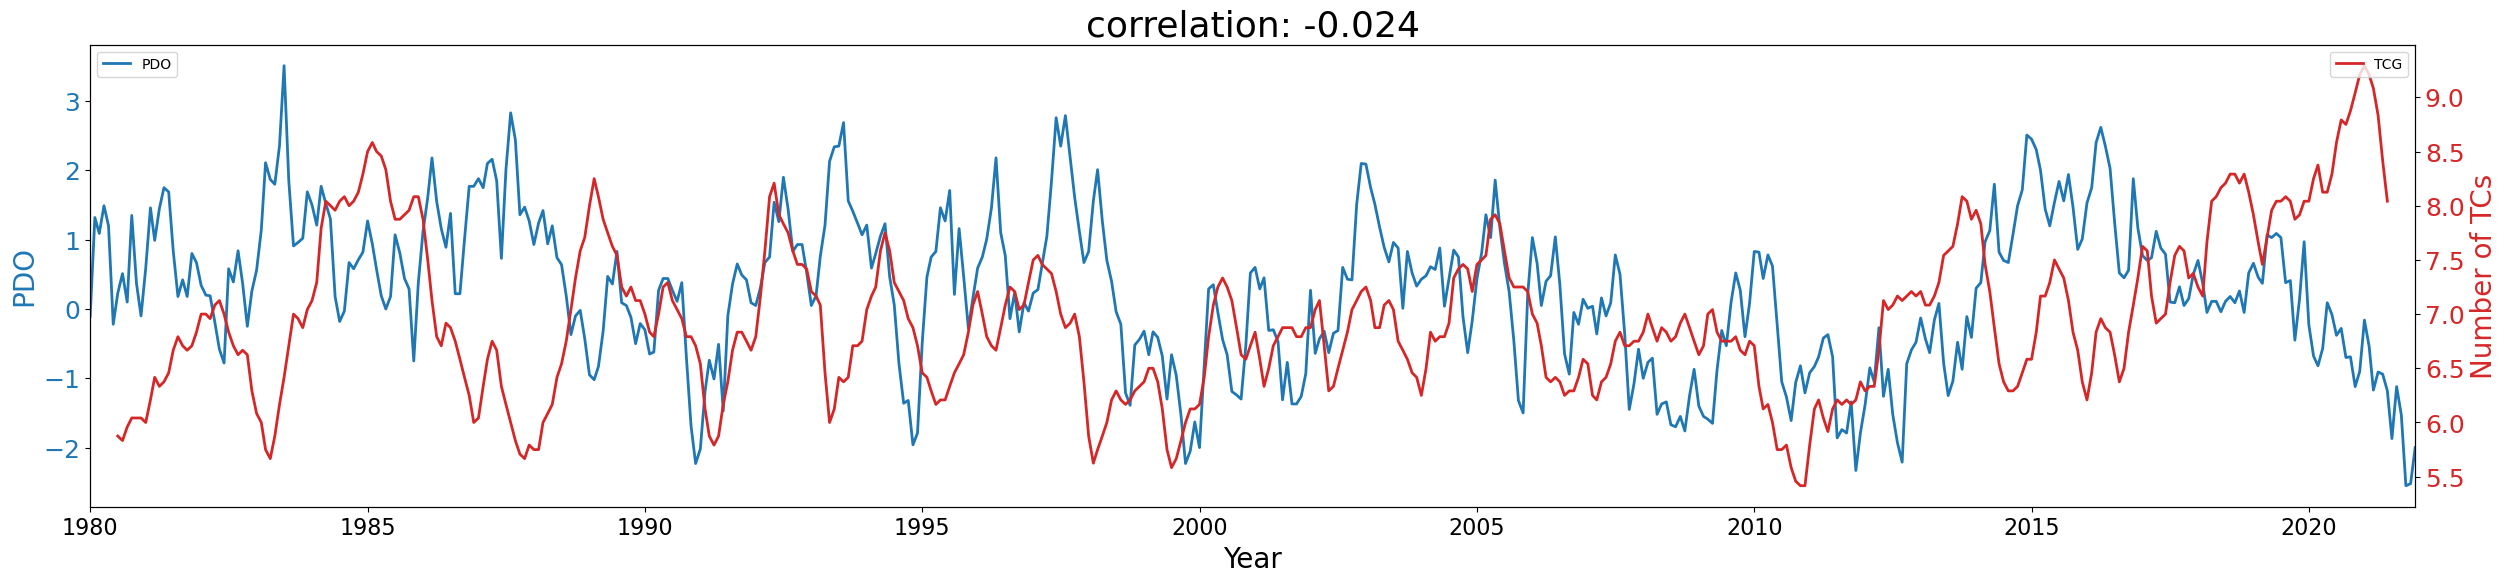

In [33]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(30, 6))

decomposition = seasonal_decompose(tcg_month.to_dataframe(), model='additive')
trend = decomposition.trend

trend_isnan = ~np.isnan(trend.values)
r, _ = pearsonr(df_pdo.values.flatten()[trend_isnan], trend.values[trend_isnan].flatten())

# Plot the first time series (PDO index) on the primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Year', size=20)
ax1.set_ylabel('PDO', color=color1, size=20)
ax1.plot(df_pdo.index, df_pdo.values, color=color1, linewidth=2, label="PDO")  # Ensure proper x-values
ax1.tick_params(axis='y', labelcolor=color1, labelsize=18)
ax1.set_title(f'correlation: {r:.3f}', size=26)

# Create a second y-axis for the second time series (TCG)
ax2 = ax1.twinx()  
color2 = 'tab:red'
ax2.set_ylabel('Number of TCs', color=color2, size=20)
ax2.plot(tcg_month.time, trend.values, color=color2, linewidth=2, label="TCG")  # Ensure proper x-values
ax2.tick_params(axis='y', labelcolor=color2, labelsize=18)

# Set x-axis format properly
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlim([df_pdo.index.min(), df_pdo.index.max()])  # Set x-axis limits to match dataset

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:
mpi_list = []
sst_list = []
for y in years:
    mpi_file = os.path.join(data_dir, 'ERA5dv', '2.5x2.5', 'MPI', 'MPI_2.5x2.5_{}.nc'.format(y))
    sst_file = os.path.join(data_dir, 'ERA5', '2.5x2.5', 'MSLP-SST', 'ERA5_MSLP-SST_2.5x2.5_{}.nc'.format(y))
    ds = xr.open_dataset(mpi_file).mpi
    mpi_list.append(ds)
    ds = xr.open_dataset(sst_file).sst
    sst_list.append(ds)
mpi_ds = xr.concat(mpi_list, dim='time')
sst_ds = xr.concat(sst_list, dim='time')

/opt/miniconda3/envs/weather/lib/python3.11/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


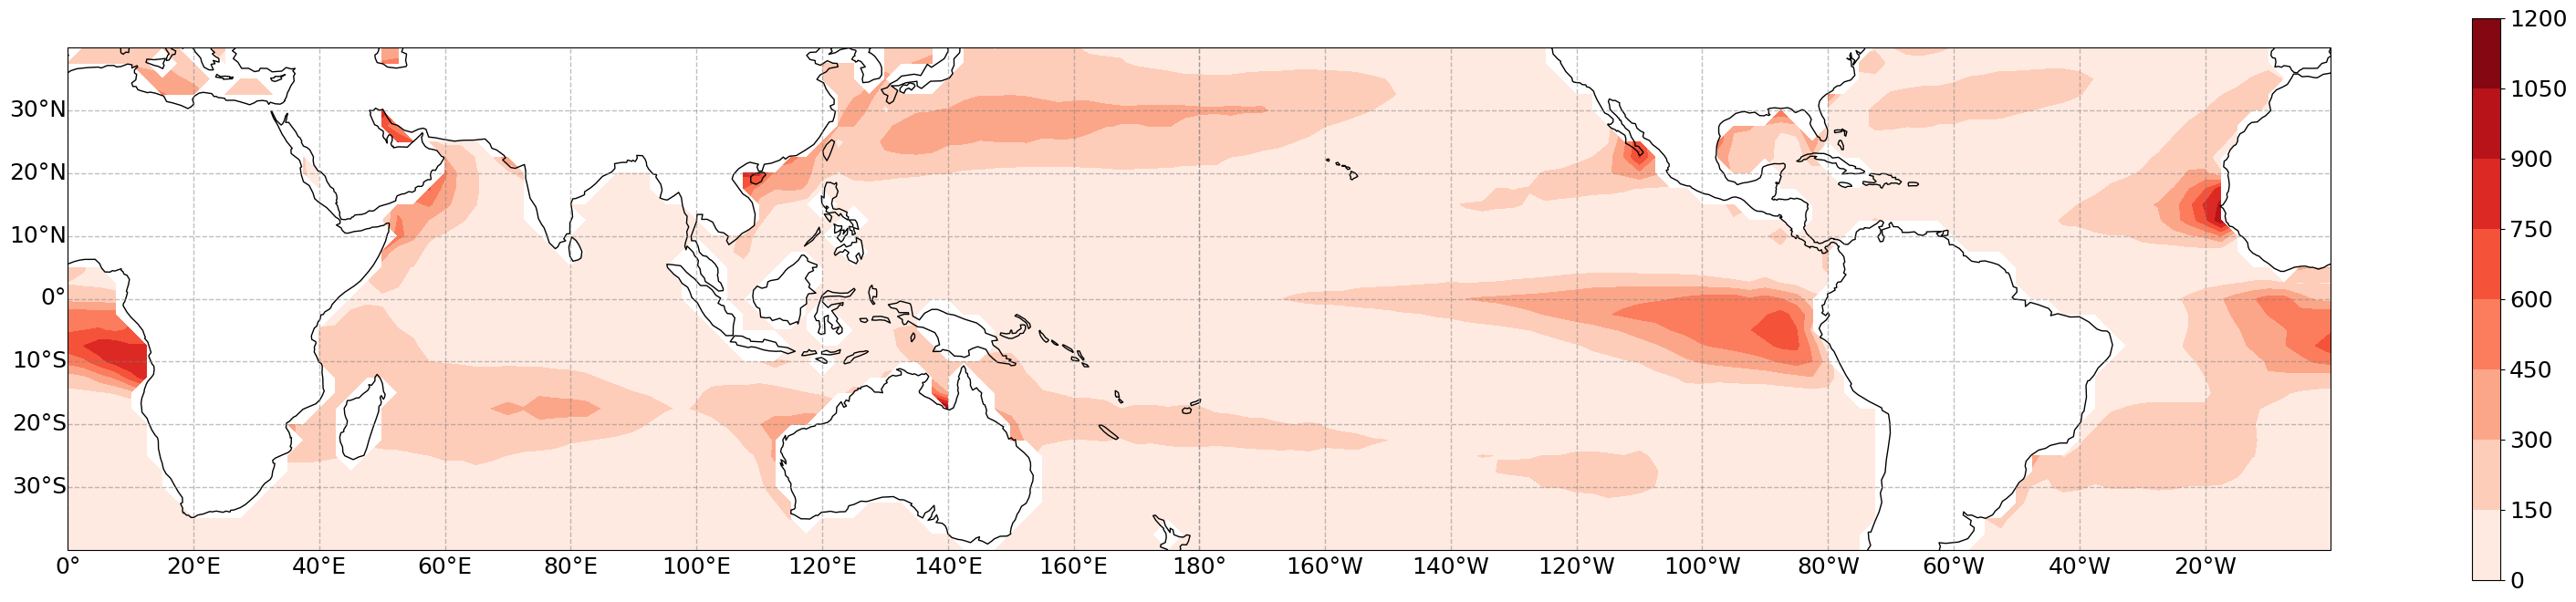

In [11]:
## Variance of MPI ## 
mpi_var = mpi_ds.var(dim='time')
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(mpi_var.values, mpi_var.longitude.values, mpi_var.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(40, 8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.contourf(clon, clat, var, transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(field)
cbar.ax.tick_params(labelsize=18)

/opt/miniconda3/envs/weather/lib/python3.11/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


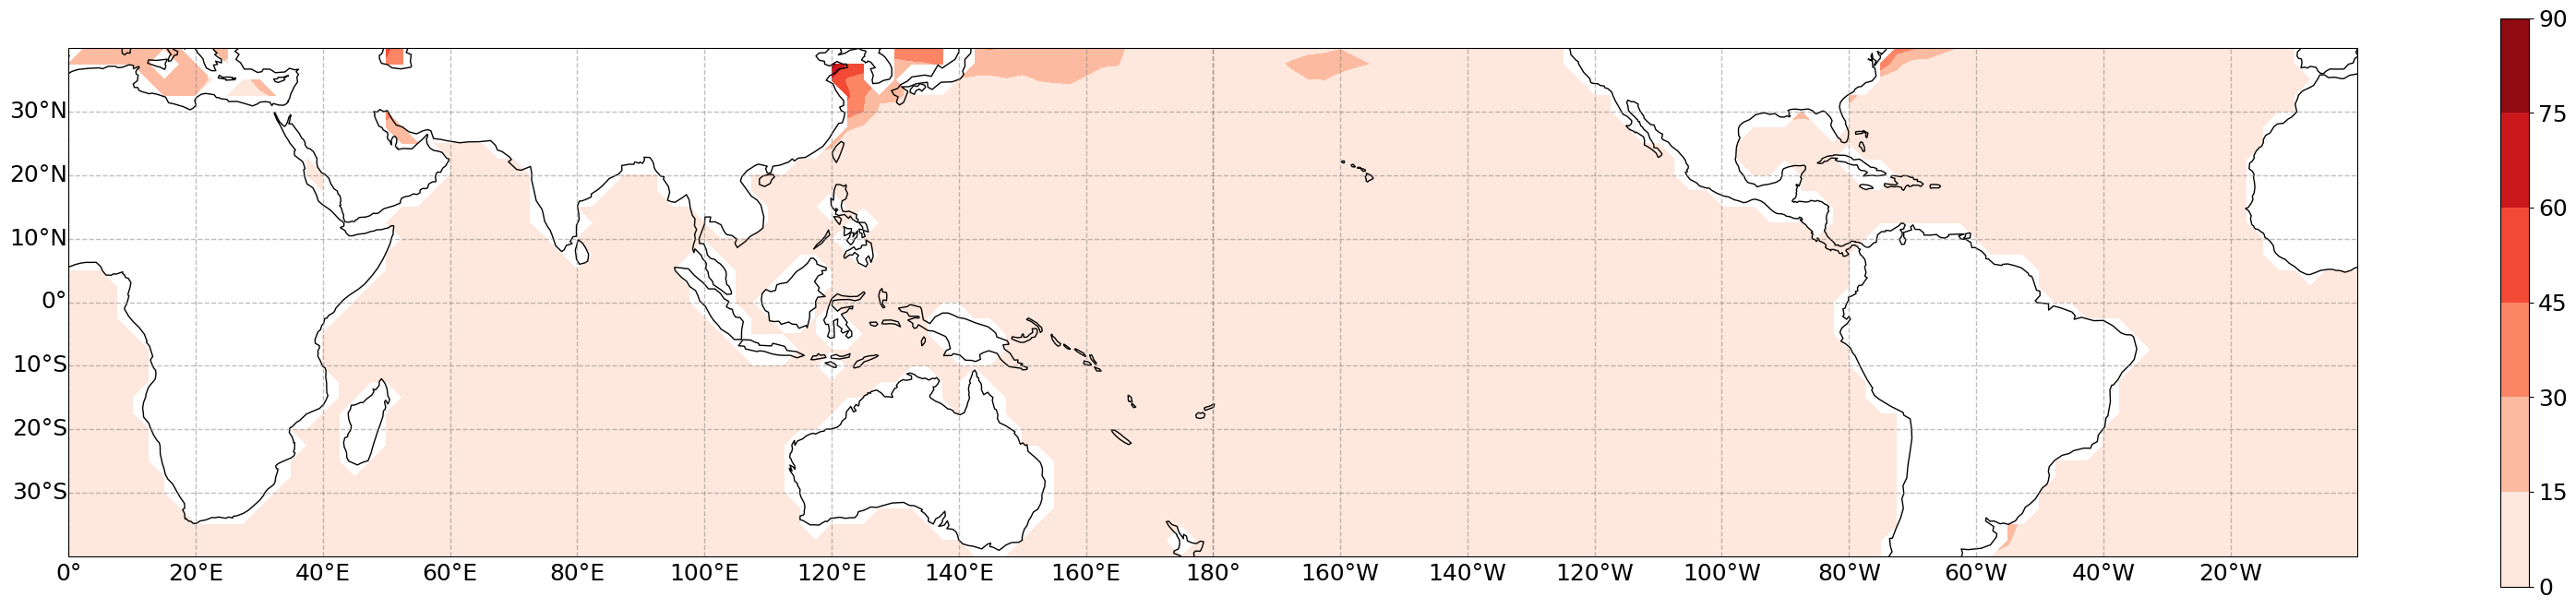

In [12]:
## Variance of SST ## 
sst_var = sst_ds.var(dim='time')
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(sst_var.values, sst_var.longitude.values, sst_var.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(40, 8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.contourf(clon, clat, var, transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(field)
cbar.ax.tick_params(labelsize=18)